In [264]:
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
# https://www.ishares.com/us/products/239706/ishares-russell-1000-growth-etf
# https://aroussi.com/post/python-yahoo-finance
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import pandas as pd
import numpy as np
import psycopg2


In [216]:
end = datetime.utcnow()
start = end - timedelta(7)

# Download Yahoo Data (5 minute interval)

In [227]:
# List of Stock Symbols
stocks = "MSFT AAPL GOOG TSLA AMZN FB KIRK V MA UNH NFLX CRM NKE HD COST KO AMT LOW UPS ZM MMM"

In [228]:
data = yf.download(stocks, start=start, end=end, interval = '5m', group_by='ticker')

[*********************100%***********************]  21 of 21 completed


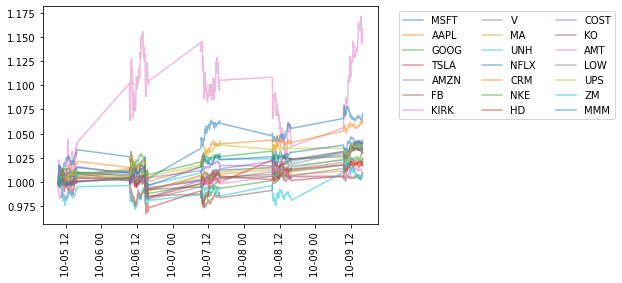

In [229]:
# Plot Time Series
timeseries = []
for stock in stocks.split():
    close = data[stock]['Close']
    timeseries.append(list(close.values/close.iloc[0]))
    close = close/close.iloc[0]
    plt.plot(close.index, close.values, '-', label = stock, alpha = .5)
    plt.plot()
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol = int(len(stocks.split())/10) + 1)
plt.show()

# Write Data to SQL

In [237]:
def get_insert(data):
    values = ""
    for sym in stocks.split():
        #sym = stocks.split()[0]
        tmp = data[sym]['Close']
        #stocks.split()[0]

        for ts in tmp.index:
            values += "('{0}', '{1}', {2}),".format(ts, sym, tmp.loc[ts])
    values = ''.join(list(values)[0:-1])
    sql = """INSERT INTO stockprice (datetime, symbol, price) VALUES {0};""".format(values)
    return sql

In [238]:
conn = psycopg2.connect("dbname='stocks' user='postgres' host='localhost' password='password'")
cur = conn.cursor()
cur.execute(get_insert(data))
cur.execute('COMMIT')

# Read Data from SQL

In [288]:
cur = conn.cursor()
sql = """SELECT * from stockprice;"""
cur.execute(sql)
data2 = pd.DataFrame(cur.fetchall())
data2.drop(0, axis = 1, inplace =  True)
data2.columns = ['timestamp', 'symbol', 'price']

In [289]:
data2.head()

,timestamp,symbol,price
0,2020-10-05 09:30:00,MSFT,207.250000
1,2020-10-05 09:35:00,MSFT,207.570007
2,2020-10-05 09:40:00,MSFT,207.990005
3,2020-10-05 09:45:00,MSFT,207.684998
4,2020-10-05 09:50:00,MSFT,207.789993


# Pivot

In [290]:
data2_piv = data2.pivot_table(columns = 'symbol', index = 'timestamp')['price']

# Normalize by First Value

In [306]:
data2_piv = data2_piv/data2_piv.iloc[0]

In [307]:
model = VAR(data2_piv)

/home/erichullander/anaconda3/envs/StockPrice/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [308]:
results = model.fit(100)

In [309]:
results.aic

-1166.9158663996989

In [310]:
lag_order = results.k_ar

In [311]:
lag_order

100

# Lags and Forecasts are in 5 minute intervals

In [317]:
forecast = pd.DataFrame(results.forecast(data2_piv.values[-lag_order:], 48))
forecast.columns = data2_piv.columns
forecast.index = range(data2_piv.shape[0], data2_piv.shape[0] + forecast.shape[0])

In [318]:
all = pd.concat((data2_piv, forecast))

# Forecast next 

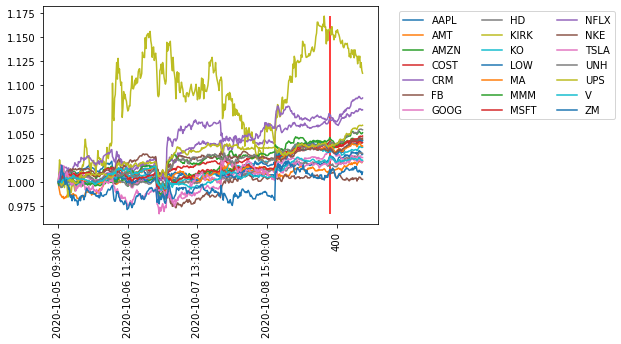

In [319]:
all.plot()
ymin = np.min(np.min(all))
ymax = np.max(np.max(all))
plt.vlines(x = data2_piv.shape[0], ymin = ymin, ymax = ymax, color = 'r')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol = int(len(stocks.split())/10) + 1)
plt.xticks(rotation=90)
plt.show()